In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import math
import pandas_datareader.data as web

import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

import math

from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')

from pandas_datareader import data as pdr
import yfinance as yfin

from config import fred_api

from fredapi import Fred
fred = Fred(api_key=fred_api)



2023-02-19 21:53:49.656619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# change as needed
company = 'AAPL'
provider = 'yahoo'


# Get stock quote
#start = datetime.datetime(2018-3-1) # Change Date if needed
start = datetime.datetime(2018, 1, 1) # Change Date if needed

end = datetime.datetime.now()



yfin.pdr_override()

df = pdr.get_data_yahoo(company, start, end)

df = df.reset_index(level=0)

[*********************100%***********************]  1 of 1 completed


In [3]:
# sp500 = fred.get_series('SP500')
# gdp = fred.get_series_latest_release('GDP')

# Retrieve interest rate data from FRED
interest_rates = fred.get_series('FEDFUNDS', observation_start=start)
empl = fred.get_series('PAYEMS', observation_start=start) # seasonally ajusted non-farm employment in thousands, All Employees, Total Nonfarm (PAYEMS)
gdp = fred.get_series('GDPC1', observation_start=start) # Seasonally adjusted real GDP 
unemp =fred.get_series('UNRATE', observation_start=start) # seasonally ajusted unemployment rate in percent
SP500=fred.get_series('SP500', observation_start=start)

# Convert index to datetime
interest_rates.index = pd.to_datetime(interest_rates.index)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df['Interest_Rate'] = interest_rates.reindex(df.index, method='nearest')
# Compute rolling average of interest rates
interest_rates_ma = interest_rates.rolling(window=20).mean()

# Combine interest rate data with stock price data
df['InterestRates_calc'] = interest_rates_ma.reindex(df.index, method='nearest')
df['InterestRates'] = interest_rates_ma.reindex(df.index, method='nearest')


df['SP500'] = SP500.reindex(df.index, method='nearest')
df['unemployment_rate'] = unemp.reindex(df.index, method='nearest')
df['gdp'] = gdp.reindex(df.index, method='nearest')
df['Nonfarm'] = empl.reindex(df.index, method='nearest') # Units:  Thousands of Persons, Seasonally Adjusted


df = df.reset_index(level=0)

df['70ma'] = df['Adj Close'].rolling(window=70).mean()
df['20ma_adj'] = df['Adj Close'].rolling(window=20).mean()
df.dropna(inplace=True)

# Calculate daily price change
df['price_change'] = df['High'] - df['Low']

# Calculate 20-day moving average
df['20ma_close'] = df['Close'].rolling(window=20).mean()

# Calculate Bollinger Bands
df['std'] = df['Close'].rolling(window=20).std()
df['upper_band'] = df['20ma_close'] + 2 * df['std']
df['lower_band'] = df['20ma_close'] - 2 * df['std']

df['upper_band'] = df['20ma_adj'] + 2 * df['std']
df['lower_band'] = df['20ma_adj'] - 2 * df['std']



print(df.shape)

print(df.tail())

(906, 21)
           Date        Open        High         Low       Close   Adj Close  \
1287 2023-02-13  150.949997  154.259995  150.919998  153.850006  153.850006   
1288 2023-02-14  152.119995  153.770004  150.860001  153.199997  153.199997   
1289 2023-02-15  153.110001  155.500000  152.880005  155.330002  155.330002   
1290 2023-02-16  153.509995  156.330002  153.350006  153.710007  153.710007   
1291 2023-02-17  152.350006  153.000000  150.850006  152.550003  152.550003   

        Volume  Interest_Rate  InterestRates_calc  InterestRates  ...  \
1287  62199000           4.33               1.256          1.256  ...   
1288  61707600           4.33               1.256          1.256  ...   
1289  65669300           4.33               1.256          1.256  ...   
1290  68167900           4.33               1.256          1.256  ...   
1291  59095900           4.33               1.256          1.256  ...   

      unemployment_rate        gdp   Nonfarm        70ma    20ma_adj  \
1287

In [4]:
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [15]:
# preprocess the data
df = df.filter(['Open', 'High', 'Low', 'Close', 'Volume',
       'Interest_Rate', 'InterestRates_calc', 'InterestRates', 'SP500',
       'unemployment_rate', 'gdp', 'Nonfarm', '70ma', '20ma_adj',
       'price_change', '20ma_close', 'std', 'upper_band', 'lower_band', 'Adj Close'])

df = df.fillna(df.mean())

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# split the data into training and testing sets
training_data_len = math.ceil(len(df) * 0.8)
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]


# prepare the training data
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 5])


x_train, y_train = np.array(x_train), np.array(y_train)
x_test = np.array(x_test)
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

# build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(20))  # change the number of units to match the number of output features
model.compile(optimizer='adam', loss='mean_squared_error')


# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# train the model
history = model.fit(x_train, y_train, batch_size=1, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# prepare the testing data
x_test = []
y_test = df.iloc[training_data_len:, :]['Adj Close'].values
test_data = scaled_data[training_data_len - 60:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)

# make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/100
532/532 [==============================] - 25s 38ms/step - loss: 0.0039 - val_loss: 0.0100
Epoch 2/100
532/532 [==============================] - 22s 41ms/step - loss: 0.0017 - val_loss: 0.0115
Epoch 3/100
532/532 [==============================] - 20s 38ms/step - loss: 0.0015 - val_loss: 0.0102
Epoch 4/100
532/532 [==============================] - 23s 43ms/step - loss: 0.0014 - val_loss: 0.0073
Epoch 5/100
532/532 [==============================] - 29s 54ms/step - loss: 0.0012 - val_loss: 0.0080
Epoch 6/100
532/532 [==============================] - 27s 51ms/step - loss: 0.0013 - val_loss: 0.0074
Epoch 7/100
532/532 [==============================] - 28s 53ms/step - loss: 0.0011 - val_loss: 0.0084
Epoch 8/100
532/532 [==============================] - 23s 44ms/step - loss: 8.3971e-04 - val_loss: 0.0079
Epoch 9/100
6/6 [==============================] - 1s 25ms/step


6/6 [==============================] - 2s 29ms/step


/var/folders/gr/77dww1vx4k945hzph39jwlc40000gn/T/ipykernel_28852/3623444885.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


KeyError: "['Adj Close'] not in index"

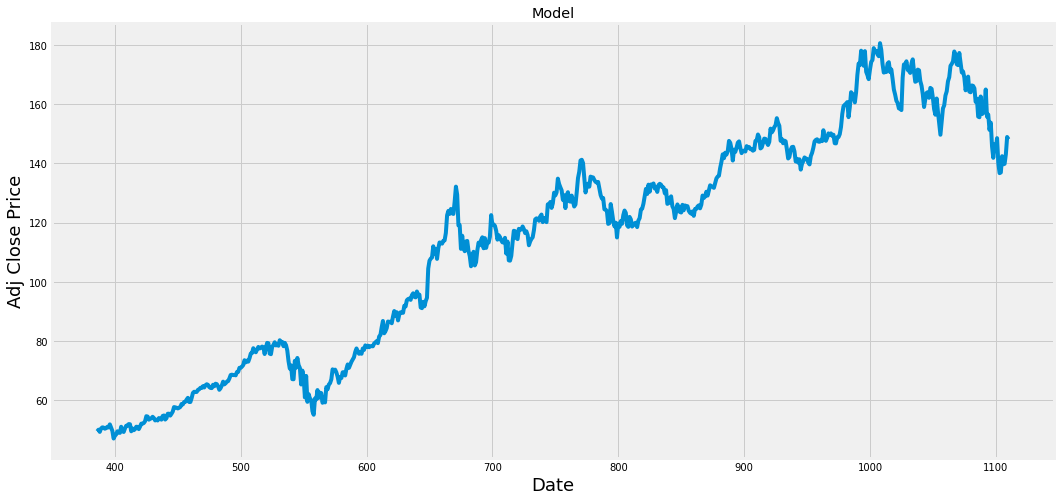

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# preprocess the data
df = df.filter(['Open', 'High', 'Low', 'Close', 'Volume',
       'Interest_Rate', 'InterestRates_calc', 'InterestRates', 'SP500',
       'unemployment_rate', 'gdp', 'Nonfarm', '70ma', '20ma_adj',
       'price_change', '20ma_close', 'std', 'upper_band', 'lower_band', 'Adj Close'])

df = df.fillna(df.mean())

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# split the data into training and testing sets
training_data_len = int(np.ceil(len(df) * 0.8))
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]

# prepare the training data
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 5])

x_train, y_train = np.array(x_train), np.array(y_train)

# build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(20))
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# prepare the testing data
x_test = []
y_test = df.iloc[training_data_len:, :]['Adj Close'].values
test_data = scaled_data[training_data_len - 60:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)

# make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# plot the results
train = df[:training_data_len]['Adj Close']
test = df[training_data_len:]['Adj Close']
test['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price', fontsize=18)
plt.plot(train)
plt.plot(test[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()


In [16]:
# store the original length of the dataframe
orig_len = len(df)

# preprocess the data
df = df.filter(['Open', 'High', 'Low', 'Close', 'Volume',             
               'Interest_Rate', 'InterestRates_calc', 'InterestRates', 'SP500',                      
               'unemployment_rate', 'gdp', 'Nonfarm', '70ma', '20ma_adj',                      
               'price_change', '20ma_close', 'std', 'upper_band', 'lower_band', 'Adj Close'])

df = df.fillna(df.mean())

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# split the data into training and testing sets
training_data_len = int(np.ceil(len(df) * 0.8))
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]

# prepare the training data
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 5])

x_train, y_train = np.array(x_train), np.array(y_train)

# prepare the testing data
x_test = []
y_test = []
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])
    y_test.append(test_data[i, 5])

x_test, y_test = np.array(x_test), np.array(y_test)

# build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(20))
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
model.fit(x_train, y_train, batch_size=10, epochs=5)

# make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)



Epoch 1/5
67/67 [==============================] - 22s 115ms/step - loss: 0.0059
Epoch 2/5
67/67 [==============================] - 7s 105ms/step - loss: 0.0019
Epoch 3/5
67/67 [==============================] - 6s 92ms/step - loss: 0.0015
Epoch 4/5
67/67 [==============================] - 6s 90ms/step - loss: 0.0013
Epoch 5/5
6/6 [==============================] - 2s 56ms/step


In [15]:

# plot the results
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price', fontsize=18)
plt.plot(df['Adj Close'][:training_data_len])
plt.plot(test_df)
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()


6/6 [==============================] - 2s 47ms/step


ValueError: Expected a 1D array, got an array with shape (181, 20)

In [13]:
# evaluate the model
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print('RMSE:', rmse)

ValueError: operands could not be broadcast together with shapes (181,20) (181,) 